## Hybrid Sim V6

### Prerequisites

In [54]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import random
import ternary
import pandas as pd

In [55]:
# Set a random seed for reproducibility (if not required comment out line)

np.random.seed(32)
random.seed(32)

In [110]:
# Alleles 
MAGENTA = 'M'
YELLOW = 'Y'

# Colour map for alleles
col_map = {MAGENTA: 'deeppink', YELLOW: 'gold'}

In [57]:
# Global Simulation Parameters
# Ensure these are at the very top of your script,
# or at least before they are first used.
chromosome_length = 100 # Number of loci per chromosome
NUM_CHROMOSOMES_F1 = 1  # F1 individuals will only have 1 diploid chromosome pair initially
NUM_CHROMOSOMES_F2 = 10 # F2 individuals will have 10 diploid chromosome pairs

NUM_P0_INDIVIDUALS = 2 # One Magenta, one Yellow
NUM_F1_INDIVIDUALS = 100 # Population size of F1
NUM_F2_INDIVIDUALS = 1000 # Population size of F2

### Classes 

In [58]:
class Chromosome:
    def __init__(self, alleles):
        self.alleles = alleles

    def __repr__(self):
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"

In [59]:
class DiploidChromosomePair:
    def __init__(self, chromatid1, chromatid2):
        self.chromatid1 = chromatid1
        self.chromatid2 = chromatid2

    def __repr__(self):
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"

In [60]:
class Individual:
    def __init__(self, num_chromosomes, num_loci_per_chromosome):
        self.num_chromosomes = num_chromosomes
        self.num_loci_per_chromosome = num_loci_per_chromosome
        self.diploid_chromosome_pairs = []

    def __repr__(self):
        return f"Individual with {len(self.diploid_chromosome_pairs)} diploid chromosome pairs."

    def calculate_hybrid_index(self):
        total_alleles = 0
        magenta_alleles = 0
        for pair in self.diploid_chromosome_pairs:
            total_alleles += len(pair.chromatid1.alleles) + len(pair.chromatid2.alleles)
            magenta_alleles += pair.chromatid1.alleles.count(MAGENTA)
            magenta_alleles += pair.chromatid2.alleles.count(MAGENTA)
        return magenta_alleles / total_alleles if total_alleles > 0 else 0

    def calculate_heterozygosity(self):
        heterozygous_loci_count = 0
        total_loci_count = 0
        for pair in self.diploid_chromosome_pairs:
            for i in range(self.num_loci_per_chromosome):
                total_loci_count += 1
                allele1 = pair.chromatid1.alleles[i]
                allele2 = pair.chromatid2.alleles[i]
                if allele1 != allele2:
                    heterozygous_loci_count += 1
        return heterozygous_loci_count / total_loci_count if total_loci_count > 0 else 0

### Recombination setup 

In [98]:
# Your recombination setup for F2
use_uniform_recomb = False  # Change to True to use constant recombination prob.
if use_uniform_recomb:
    # FIX HERE: Length should be chromosome_length - 1
    recomb_probs_for_f2 = [0.1] * (chromosome_length - 1)
else:
    # This part was already correct for length
    recomb_probs_for_f2 = [0.0] * (chromosome_length - 1)
    for i in range(chromosome_length - 1):
        if 45 <= i < 55:
            recomb_probs_for_f2[i] = 0.1

# Define the chance of a recombination event happening (0, 1, or 2 crossover events)
recomb_event_probs_for_f2 = [0, 1.0, 0]

### Parent generation

In [65]:
# P0 Generation
def create_parent(allele_type, num_chromosomes, num_loci_per_chromosome):
    individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for _ in range(num_chromosomes):
        chromatid1 = Chromosome([allele_type] * num_loci_per_chromosome)
        chromatid2 = Chromosome([allele_type] * num_loci_per_chromosome)
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))
    return individual

parent_magenta = create_parent(MAGENTA, NUM_CHROMOSOMES_F1, chromosome_length)
parent_yellow = create_parent(YELLOW, NUM_CHROMOSOMES_F1, chromosome_length)

P0 Magenta Parent Hybrid Index: 1.0
P0 Yellow Parent Hybrid Index: 0.0


In [66]:
print("P0 Magenta Parent Hybrid Index:", parent_magenta.calculate_hybrid_index())
print("P0 Yellow Parent Hybrid Index:", parent_yellow.calculate_hybrid_index())

P0 Magenta Parent Hybrid Index: 1.0
P0 Yellow Parent Hybrid Index: 0.0


### F1 generation

In [69]:
# F1 Generation - All MY
def create_f1_individual_no_recomb(parent_magenta_template, parent_yellow_template, num_chromosomes, num_loci_per_chromosome):
    f1_individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for i in range(num_chromosomes):
        f1_individual.diploid_chromosome_pairs.append(
            DiploidChromosomePair(
                Chromosome([MAGENTA] * num_loci_per_chromosome),
                Chromosome([YELLOW] * num_loci_per_chromosome)
            )
        )
    return f1_individual

f1_population = []
for _ in range(NUM_F1_INDIVIDUALS):
    f1_population.append(create_f1_individual_no_recomb(
        parent_magenta, parent_yellow, NUM_CHROMOSOMES_F1, chromosome_length
    ))

print("\nF1 Population Example:")
print("Hybrid Index:", f1_population[0].calculate_hybrid_index())
print("Heterozygosity:", f1_population[0].calculate_heterozygosity())


F1 Population Example:
Hybrid Index: 0.5
Heterozygosity: 1.0


### F2 generation

In [99]:
def form_gamete_from_diploid_pair(diploid_chromosome_pair, chromosome_length, recomb_event_probs, recomb_probs):
    """
    Forms a single gamete chromatid from a diploid chromosome pair with recombination,
    using defined probabilities for crossover events and positions.
    """
    parent_alleles_strand1 = diploid_chromosome_pair.chromatid1.alleles
    parent_alleles_strand2 = diploid_chromosome_pair.chromatid2.alleles

    # Decide how many recombination events to simulate
    # Ensure num_recombs doesn't exceed chromosome_length - 1 (max possible crossover points)
    num_recombs = random.choices([0, 1, 2], weights=recomb_event_probs, k=1)[0]

    if chromosome_length <= 1: # No recombination possible for 1 locus
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # Cap num_recombs at the maximum number of unique crossover points possible
    max_crossovers_possible = chromosome_length - 1
    num_recombs = min(num_recombs, max_crossovers_possible)

    # Get crossover points based on `recomb_probs`
    # `recomb_probs` should be weights for `range(0, chromosome_length - 1)`
    # where index `i` corresponds to a crossover *between* locus `i` and `i+1`.
    if sum(recomb_probs) > 0 and num_recombs > 0:
        # random.choices selects with replacement, but crossovers should be unique points
        # If num_recombs is large and sum(recomb_probs) is low, it might struggle to find unique points.
        # For simplicity, we'll use `random.choices` for picking points based on weights,
        # then sort and make them unique. However, if `num_recombs` is > 1, and your
        # `recomb_probs` has many zeros, it might struggle to find enough unique points.
        # A more robust way would be to iteratively pick points.
        
        # Simpler for now: pick indices for crossover points (0 to chromosome_length-2)
        # These indices map to positions *between* loci.
        crossover_point_indices = random.choices(range(max_crossovers_possible), weights=recomb_probs, k=num_recombs)
        crossover_points = sorted(list(set(crossover_point_indices))) # Ensure unique and sorted
        
        # If after unique sorting, we don't have enough points for num_recombs,
        # then we might have fewer actual crossovers than intended by recomb_event_probs.
        # For this setup, it's generally fine, but worth noting.
    else:
        crossover_points = [] # No recombination if probabilities sum to 0 or num_recombs is 0

    # If 0 recombination (either by choice or if no valid crossover points),
    # then just return a full copy of one of the parental strands.
    if num_recombs == 0 or not crossover_points:
         chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
         return Chromosome(list(chosen_strand))
    # Recombine between strands
    # Start with a randomly chosen strand
    current_source_alleles = list(parent_alleles_strand1) if random.random() < 0.5 else list(parent_alleles_strand2)
    other_source_alleles = list(parent_alleles_strand2) if current_source_alleles == list(parent_alleles_strand1) else list(parent_alleles_strand1)

    gamete_alleles = [None] * chromosome_length
    current_segment_start_idx = 0

    for crossover_point_idx in crossover_points:
        # Crossover occurs *after* locus `crossover_point_idx`.
        # So, the segment up to `crossover_point_idx + 1` comes from current_source.
        # Then we swap.
        segment_end = crossover_point_idx + 1 # Slice up to this index (exclusive)

        # Copy segment from current source
        for i in range(current_segment_start_idx, segment_end):
            gamete_alleles[i] = current_source_alleles[i]

        # Swap source for the next segment
        current_source_alleles, other_source_alleles = other_source_alleles, current_source_alleles
        current_segment_start_idx = segment_end # New start for the next segment

    # Copy the remaining segment from the final source
    for i in range(current_segment_start_idx, chromosome_length):
        gamete_alleles[i] = current_source_alleles[i]

    return Chromosome(gamete_alleles)

In [141]:
def produce_haploid_set_of_chromosomes_for_gamete(parent_individual, chromosome_length, recomb_event_probs, recomb_probs, target_num_chromosomes_in_gamete_set=None):
    """
    Generates a complete haploid set of chromosomes (a gamete) from a parent individual.
    Each diploid pair contributes one recombinant chromatid.
    If parent has fewer actual chromosome pairs than target, it replicates the gamete from its first pair.

    Args:
        parent_individual (Individual): The parent individual producing the gamete.
        chromosome_length (int): Length of each chromosome.
        recomb_event_probs (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probs (list): Probabilities for crossover at each specific locus.
        target_num_chromosomes_in_gamete_set (int, optional): The desired number of chromatids in the returned gamete set.
                                                              If parent has fewer physical chromosome pairs, it replicates the gamete
                                                              from its first chromosome pair to meet this target.
                                                              If None, returns as many as the parent has.

    Returns:
        list: A list of Chromosome objects, representing a full haploid gamete.
    """
    gamete_chromatids = []

    # If the parent has no chromosome pairs at all, return an empty list
    if not parent_individual.diploid_chromosome_pairs:
        return []

    # Determine how many chromatids to generate
    if target_num_chromosomes_in_gamete_set is None:
        num_to_generate = parent_individual.num_chromosomes
    else:
        num_to_generate = target_num_chromosomes_in_gamete_set

    # Generate the gamete from the first chromosome pair, which will be replicated if needed
    # For P0 parents, this will be a pure M or pure Y chromatid.
    # For F1/F2, this will be a recombinant chromatid from their first pair.
    gamete_from_first_pair = form_gamete_from_diploid_pair(
        parent_individual.diploid_chromosome_pairs[0], # Always use the first pair
        chromosome_length, recomb_event_probs, recomb_probs
    )

    for i in range(num_to_generate):
        # If the parent has an actual i-th chromosome pair, generate a gamete from it
        if i < parent_individual.num_chromosomes:
            gamete_chromatids.append(
                form_gamete_from_diploid_pair(
                    parent_individual.diploid_chromosome_pairs[i],
                    chromosome_length, recomb_event_probs, recomb_probs
                )
            )
        else:
            # If the parent has fewer physical chromosome pairs than the target,
            # replicate the gamete from its first chromosome pair.
            # This is crucial for P0 parents contributing to F2/BC generations.
            gamete_chromatids.append(gamete_from_first_pair)

    return gamete_chromatids

In [142]:
def generate_f2_offspring(f1_parent_a, f1_parent_b, num_chromosomes_for_f2, chromosome_length, recomb_event_probs, recomb_probs):
    gamete_a_chromosomes = produce_gamete_for_f2(f1_parent_a, num_chromosomes_for_f2, chromosome_length, recomb_event_probs, recomb_probs)
    gamete_b_chromosomes = produce_gamete_for_f2(f1_parent_b, num_chromosomes_for_f2, chromosome_length, recomb_event_probs, recomb_probs)

    f2_individual = Individual(num_chromosomes_for_f2, chromosome_length)
    for i in range(num_chromosomes_for_f2):
        f2_individual.diploid_chromosome_pairs.append(
            DiploidChromosomePair(gamete_a_chromosomes[i], gamete_b_chromosomes[i])
        )
    return f2_individual

In [102]:
# --- Main simulation loop for F2 generation ---
f2_population = []

# Randomly shuffle F1 indices and pair them up
f1_indices = np.random.permutation(len(f1_population))
if len(f1_indices) % 2 != 0:
    f1_indices = f1_indices[:-1]
pairs = list(zip(f1_indices[::2], f1_indices[1::2]))

# Use the loop that reuses F1 parents to hit target F2 population size
while len(f2_population) < NUM_F2_INDIVIDUALS:
    parent_a = random.choice(f1_population)
    parent_b = random.choice(f1_population)

    f2_individual = generate_f2_offspring(
        parent_a, parent_b, NUM_CHROMOSOMES_F2, chromosome_length, recomb_event_probs_for_f2, recomb_probs_for_f2
    )
    f2_population.append(f2_individual)

In [103]:
# Check point 
print(f"\nF2 Population created with {len(f2_population)} individuals.")
print(f"Example F2 individual (first one):")
print(f2_population[0])
print("Hybrid Index:", f2_population[0].calculate_hybrid_index())
print("Heterozygosity:", f2_population[0].calculate_heterozygosity())


F2 Population created with 1000 individuals.
Example F2 individual (first one):
Individual with 10 diploid chromosome pairs.
Hybrid Index: 0.497
Heterozygosity: 0.406


In [18]:
# Diagnostic check
print(f"Number of F2 individuals: {len(f2_population)}")

Number of F2 individuals: 50


In [22]:
# Check the first 3 F2 individuals
# Only shows positions 45-55 
for i in range(3):
    ind = f2_population[i]
    print(f"\nF2 Individual {i+1}:")
    print(f"  Chromosome 1 alleles (pos 45-55): {ind[0][45:56]}")
    print(f"  Chromosome 2 alleles (pos 45-55): {ind[1][45:56]}")
    print(f"  Lengths: chr1 = {len(ind[0])}, chr2 = {len(ind[1])}")


F2 Individual 1:
  Chromosome 1 alleles (pos 45-55): ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'Y', 'Y', 'Y', 'Y']
  Chromosome 2 alleles (pos 45-55): ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'M']
  Lengths: chr1 = 100, chr2 = 100

F2 Individual 2:
  Chromosome 1 alleles (pos 45-55): ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
  Chromosome 2 alleles (pos 45-55): ['Y', 'Y', 'Y', 'Y', 'Y', 'M', 'M', 'M', 'M', 'M', 'M']
  Lengths: chr1 = 100, chr2 = 100

F2 Individual 3:
  Chromosome 1 alleles (pos 45-55): ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']
  Chromosome 2 alleles (pos 45-55): ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'M', 'M', 'M', 'M']
  Lengths: chr1 = 100, chr2 = 100


In [24]:
print("\nChecking for completely homozygous F2 individuals...")
for i, ind in enumerate(f2_population):
    homo_count = sum(1 for a1, a2 in zip(ind[0], ind[1]) if a1 == a2)
    if homo_count == chromosome_length:
        print(f"  WARNING: F2 individual {i} is fully homozygous!")


Checking for completely homozygous F2 individuals...


In [ ]:
# Print F2 individual 10 (the fully homozygous one)
ind = f2_population[10]  # Index 10 for individual 10 (assuming 0-based indexing)
print(f"\nF2 Individual 10 (fully homozygous):")
print(f"  Chromosome 1 alleles (pos 45-55): {ind[0][45:56]}")
print(f"  Chromosome 2 alleles (pos 45-55): {ind[1][45:56]}")
print(f"  Chromosome 1 alleles (full): {ind[0]}")
print(f"  Chromosome 2 alleles (full): {ind[1]}")
print(f"  Lengths: chr1 = {len(ind[0])}, chr2 = {len(ind[1])}")

# Check if they're identical
if ind[0] == ind[1]:
    print("  Status: Both chromosomes are identical (fully homozygous)")
else:
    print("  Status: Chromosomes differ (this shouldn't happen if warning is correct)")

In [26]:
# Function to check recomb events 
def check_recombination_in_f2(f2_population):
    recomb_count = 0
    for idx, (chr1, chr2) in enumerate(f2_population):
        chr1_set = set(chr1)
        chr2_set = set(chr2)

        chr1_recombined = MAGENTA in chr1_set and YELLOW in chr1_set
        chr2_recombined = MAGENTA in chr2_set and YELLOW in chr2_set

        if chr1_recombined or chr2_recombined:
            recomb_count += 1

    print(f"{recomb_count} out of {len(f2_population)} F2 individuals have at least one recombined chromosome.")

In [27]:
check_recombination_in_f2(f2_population)

50 out of 50 F2 individuals have at least one recombined chromosome.


### Convert to genotype numerics and labels 

In [104]:
# Assuming MAGENTA = 'M' and YELLOW = 'Y' are defined globally as before

# Compute genotype numeric representation
# Lists to store data for the entire F2 population
f2_genotype_numeric_all = []    # List of lists (each individual's numeric genotypes for all chromosomes)
f2_genotype_labels_all = []     # List of lists (each individual's genotype labels for all chromosomes)

# Loop over each individual in the F2 population
for individual in f2_population:

    # Initialize lists for this individual's combined genotype across all chromosomes
    individual_numeric_genotypes = []
    individual_label_genotypes = []

    # Loop through each diploid chromosome pair for this individual
    for diploid_pair in individual.diploid_chromosome_pairs:

        # Get the alleles from the two homologous chromatids in this pair
        # Ensure we are working with the allele lists
        alleles_chromatid1 = diploid_pair.chromatid1.alleles
        alleles_chromatid2 = diploid_pair.chromatid2.alleles

        # Loop through alleles at each position (locus) from both chromatids in the pair
        # Remember chromosome_length is the number of loci on each chromatid
        for i in range(individual.num_loci_per_chromosome):
            allele_a = alleles_chromatid1[i]
            allele_b = alleles_chromatid2[i]

            pair = sorted([allele_a, allele_b])  # Sort to standardise MM, MY, etc.

            if pair == [MAGENTA, MAGENTA]: # Use the MAGENTA constant
                individual_numeric_genotypes.append(2)
                individual_label_genotypes.append('MM')
            elif pair == [YELLOW, YELLOW]: # Use the YELLOW constant
                individual_numeric_genotypes.append(0)
                individual_label_genotypes.append('YY')
            else: # Must be heterozygous
                individual_numeric_genotypes.append(1)
                individual_label_genotypes.append('MY') # Standardize to 'MY' rather than 'YM' or 'MY'
                                                      # since we sorted the pair, it will always be 'MY'

    # Append this individual's complete genotype data (across all chromosomes)
    # to the population-level lists
    f2_genotype_numeric_all.append(individual_numeric_genotypes)
    f2_genotype_labels_all.append(individual_label_genotypes)

In [ ]:
# Check point 
print("\nExample F2 Individual Genotype (Numeric, first 20 loci of first individual):")
print(f2_genotype_numeric_all[0][:20])
print("\nExample F2 Individual Genotype (Labels, first 20 loci of first individual):")
print(f2_genotype_labels_all[0][:20])

### Visualisation (P0 and F1)

In [112]:
def plot_individual_chromosomes(individuals_to_plot, titles, loci_per_chromosome, max_chromosomes_to_plot=None):
    """
    Visualises the alleles along chromosomes for one or more individuals.

    Args:
        individuals_to_plot (list): A list of Individual objects to visualize.
        titles (list): A list of titles for each individual, matching the order of individuals_to_plot.
        loci_per_chromosome (int): The length of each chromosome (number of loci).
        max_chromosomes_to_plot (int, optional): Maximum number of diploid chromosome pairs to plot per individual.
                                                 If None, plots all pairs. Useful for F2 individuals with many chromosomes.
    """
    if not individuals_to_plot:
        print("No individuals to plot.")
        return

    num_individuals = len(individuals_to_plot)
    
    # Calculate the total number of subplots needed: 2 chromatids * N chromosome pairs per individual * num_individuals
    # We only plot up to max_chromosomes_to_plot pairs
    num_chromatids_to_display_per_individual = min(
        max_chromosomes_to_plot if max_chromosomes_to_plot is not None else float('inf'),
        individuals_to_plot[0].num_chromosomes # Assumes all individuals have the same number of chromosomes
    ) * 2 # Multiply by 2 for the two chromatids in a diploid pair

    total_subplots = num_individuals * num_chromatids_to_display_per_individual

    # Dynamically scale figure width: ~0.1 inch per locus per chromosome + spacing
    # Adjusting based on actual content to prevent extremely wide plots for many individuals/chroms
    # Each chromatid takes ~0.2-0.3 unit width on average + 0.4 wspace = 0.6-0.7 per chromatid
    # We'll use 0.25 units per chromatid and 0.4 for wspace (total ~0.65 per chromatid axis)
    # Plus a little extra for titles and legend.
    fig_width = total_subplots * 0.7 # A rough estimate, you might fine-tune this
    fig_height = (loci_per_chromosome * 0.05) + 2 # Height adapts to chromosome length

    # Ensure min width for readability
    fig_width = max(8, fig_width)
    fig_height = max(5, fig_height)


    # Create subplots
    fig, axs = plt.subplots(1, total_subplots, figsize=(fig_width, fig_height), sharey=True)

    # If there's only one subplot, axs is not an array, so make it one
    if total_subplots == 1:
        axs = [axs]

    # Drawing settings
    block_width = 0.6
    block_height = 1
    block_spacing = 1.2 # Vertical spacing between loci

    current_subplot_idx = 0
    for ind_idx, individual in enumerate(individuals_to_plot):
        # Loop through each diploid chromosome pair (up to max_chromosomes_to_plot)
        for pair_idx in range(min(len(individual.diploid_chromosome_pairs), num_chromatids_to_display_per_individual // 2 if num_chromatids_to_display_per_individual is not None else len(individual.diploid_chromosome_pairs))):
            diploid_pair = individual.diploid_chromosome_pairs[pair_idx]

            # Plot chromatid 1
            ax_chr1 = axs[current_subplot_idx]
            for k, allele in enumerate(diploid_pair.chromatid1.alleles):
                y_pos = k * block_spacing
                ax_chr1.add_patch(
                    mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr1.set_xlim(0, 1)
            ax_chr1.set_ylim(0, loci_per_chromosome * block_spacing)
            ax_chr1.axis('off')
            ax_chr1.text(0.5, -0.05, f"Chr {pair_idx+1}a", ha='center', va='top', fontsize=9, transform=ax_chr1.transAxes) # 'a' for first chromatid
            current_subplot_idx += 1

            # Plot chromatid 2
            ax_chr2 = axs[current_subplot_idx]
            for k, allele in enumerate(diploid_pair.chromatid2.alleles):
                y_pos = k * block_spacing
                ax_chr2.add_patch(
                    mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr2.set_xlim(0, 1)
            ax_chr2.set_ylim(0, loci_per_chromosome * block_spacing)
            ax_chr2.axis('off')
            ax_chr2.text(0.5, -0.05, f"Chr {pair_idx+1}b", ha='center', va='top', fontsize=9, transform=ax_chr2.transAxes) # 'b' for second chromatid
            current_subplot_idx += 1

        # Add individual titles centered above each pair of chromosomes
        # Find the mid-point of the subplots for this individual
        start_ax_idx_for_ind = ind_idx * (num_chromatids_to_display_per_individual)
        end_ax_idx_for_ind = start_ax_idx_for_ind + (num_chromatids_to_display_per_individual - 1)
        
        mid_x = axs[start_ax_idx_for_ind].get_position().x0 + \
                (axs[end_ax_idx_for_ind].get_position().x1 - axs[start_ax_idx_for_ind].get_position().x0) / 2
        
        fig.text(mid_x, 0.95, titles[ind_idx], ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Remove only top and right spines from the figure (not individual axes)
    # This might be tricky if you want a shared border. Your old code had individual axes 'off'
    # and then drawing lines for the axes. With multiple subplots, usually you turn off spines
    # for each axis or manage them on the figure level. 'axis('off')' takes care of that.

    # Add global legend
    legend_patches = [
        mpatches.Patch(color=col_map[MAGENTA], label=f'{MAGENTA} (Magenta)'),
        mpatches.Patch(color=col_map[YELLOW], label=f'{YELLOW} (Yellow)')
    ]
    # Place legend outside the plot, to the right
    fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

    plt.subplots_adjust(wspace=0.1) # Reduce horizontal spacing between subplots
    plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for the legend
    plt.show()


--- Visualising P0 Gen Parents ---


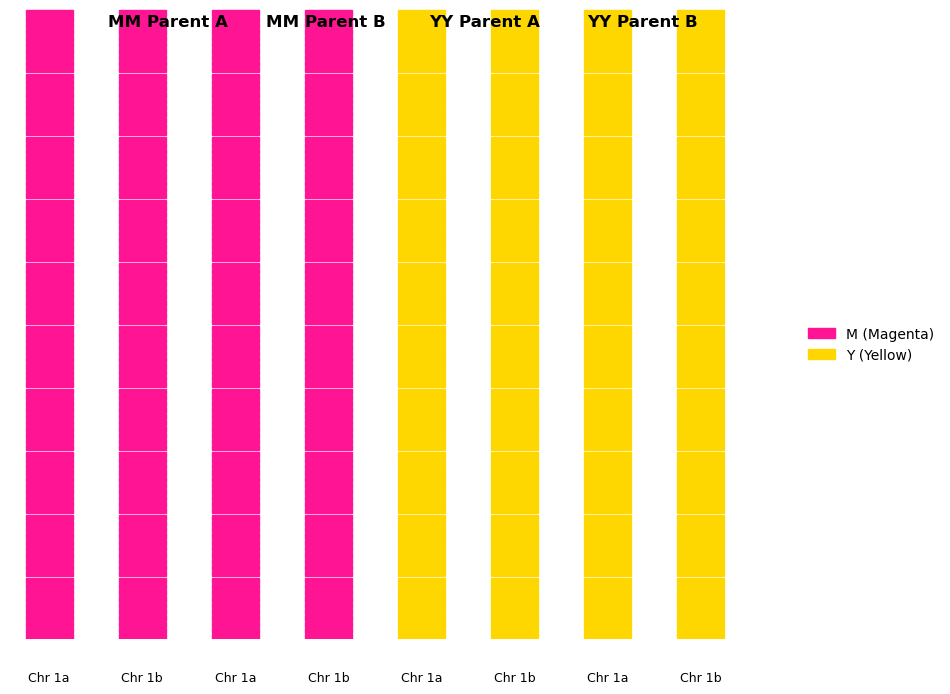

In [116]:
# Plotting P0 Parents
# Note: P0 parents have only 1 diploid chromosome pair initially (NUM_CHROMOSOMES_F1)
# but for visualization, we can just grab their single pair.
# The create_parent function makes each chromatid homozygous for that allele.
# We are plotting 1 MM parent and 1 YY parent.

# For the MM Parent (parent_magenta), let's get its first diploid pair.
# The 'create_parent' function builds an Individual with `NUM_CHROMOSOMES_F1` pairs.
# If NUM_CHROMOSOMES_F1 was 1, it has 1 pair.
# parent_magenta has two chromatids, both full 'M'.
# parent_yellow has two chromatids, both full 'Y'.

# To match your old plot, you might have created two MM parents (A & B) and two YY parents.
# In our current setup, parent_magenta is *the* MM parent, and parent_yellow is *the* YY parent.
# Each of these Individual objects has 1 diploid chromosome pair.

# Let's create a *second* "MM Parent B" and "YY Parent B" just for visualization symmetry if desired.
# Otherwise, we just visualize parent_magenta and parent_yellow.
# For simplicity and to match the 'A' and 'B' from your old code,
# let's assume 'parent_magenta' is 'MM Parent A' and we create another identical 'MM Parent B'
# The same for 'YY Parent A' and 'YY Parent B'

# If you just want one of each parent, simplify this list:
individuals_for_p0_plot = [parent_magenta, parent_yellow]
titles_for_p0_plot = ["MM Parent", "YY Parent"]

# If you want to replicate your old 4-column plot with MM A, MM B, YY A, YY B:
# (Assuming your create_parent function is how you get more parents)
mm_parent_a_vis = create_parent(MAGENTA, NUM_CHROMOSOMES_F1, chromosome_length)
mm_parent_b_vis = create_parent(MAGENTA, NUM_CHROMOSOMES_F1, chromosome_length)
yy_parent_a_vis = create_parent(YELLOW, NUM_CHROMOSOMES_F1, chromosome_length)
yy_parent_b_vis = create_parent(YELLOW, NUM_CHROMOSOMES_F1, chromosome_length)

individuals_for_p0_plot = [mm_parent_a_vis, mm_parent_b_vis, yy_parent_a_vis, yy_parent_b_vis]
titles_for_p0_plot = ["MM Parent A", "MM Parent B", "YY Parent A", "YY Parent B"]


print("\n--- Visualising P0 Gen Parents ---")
plot_individual_chromosomes(individuals_for_p0_plot, titles_for_p0_plot, chromosome_length)


--- Visualising an F1 Offspring ---


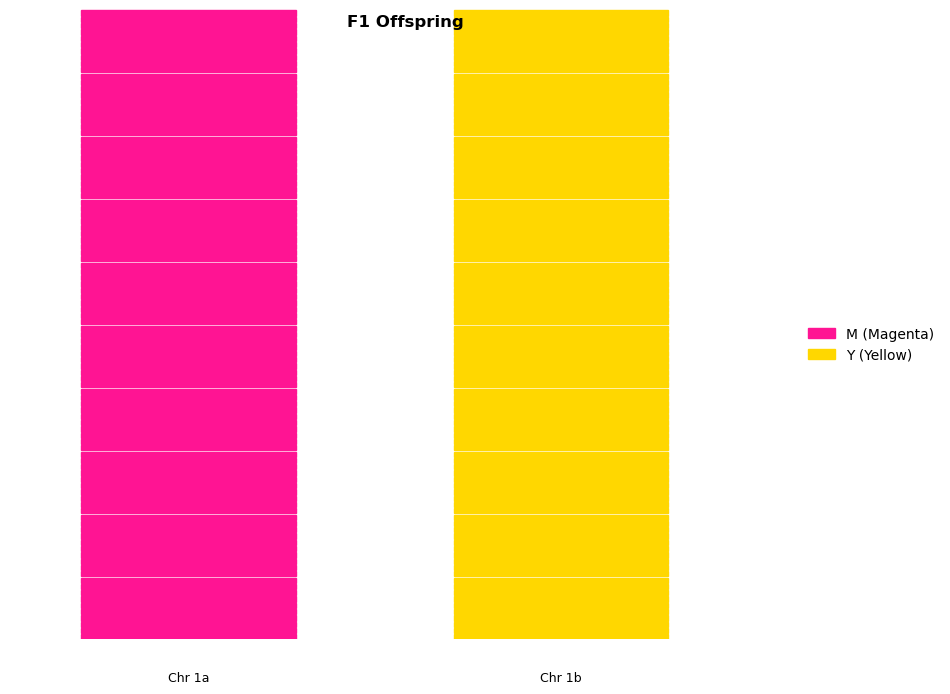

In [117]:
# Plotting an F1 offspring
f1_example_individual = f1_population[0] # Take the first F1 individual as an example

print("\n--- Visualising an F1 Offspring ---")
plot_individual_chromosomes([f1_example_individual], ["F1 Offspring"], chromosome_length)

### F3 Generation 

In [147]:
# Replace your previous `generate_backcross_offspring` definition with this:
def generate_offspring(parent1_individual, parent2_individual,
                         chromosome_length, recomb_event_probs, recomb_probs):
    """
    Generates a single offspring from two parent individuals through sexual reproduction.

    Args:
        parent1_individual (Individual): The first parent.
        parent2_individual (Individual): The second parent.
        chromosome_length (int): Length of each chromosome.
        recomb_event_probs (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probs (list): Probabilities for crossover at each specific locus.

    Returns:
        Individual: A new offspring Individual object.
    """
    # Each parent contributes a haploid set of chromosomes.
    # The `target_num_chromosomes_in_gamete_set` ensures that if a parent (like P0)
    # has fewer chromosome pairs than the offspring will have, its gamete's chromosomes
    # are replicated to match the offspring's total homologous pairs.
    # For F2xN, both parents will have NUM_CHROMOSOMES_F2, so this just passes that number.
    gamete1_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent1_individual, chromosome_length, recomb_event_probs, recomb_probs,
        target_num_chromosomes_in_gamete_set=parent1_individual.num_chromosomes # Assumes offspring will have this many
    )
    gamete2_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent2_individual, chromosome_length, recomb_event_probs, recomb_probs,
        target_num_chromosomes_in_gamete_set=parent1_individual.num_chromosomes # Match parent1's expected number of chromosomes
    )

    num_chromosomes_for_offspring = parent1_individual.num_chromosomes # Offspring will have same number of pairs as parent1

    offspring_individual = Individual(num_chromosomes_for_offspring, chromosome_length)
    for i in range(num_chromosomes_for_offspring):
        # Combine one chromatid from each gamete to form a diploid pair
        offspring_individual.diploid_chromosome_pairs.append(
            DiploidChromosomePair(gamete1_chromosomes[i], gamete2_chromosomes[i])
        )
    return offspring_individual

In [148]:
import random # Make sure random is imported

def create_f3_population(f2_population_pool, num_f3_individuals,
                         chromosome_length, recomb_event_probs, recomb_probs):
    """
    Generates an F3 population by interbreeding individuals from the F2 population.

    Args:
        f2_population_pool (list): The list of F2 Individual objects to choose parents from.
        num_f3_individuals (int): The desired size of the F3 population.
        chromosome_length (int): Length of each chromosome.
        recomb_event_probs (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probs (list): Probabilities for crossover at each specific locus.

    Returns:
        list: A list of Individual objects representing the F3 population.
    """
    f3_population = []
    print(f"Creating an F3 population of {num_f3_individuals} individuals from F2 intercross...")

    if len(f2_population_pool) < 2 and num_f3_individuals > 0:
        print("Warning: F2 population is too small to generate F3s requiring two distinct parents. (If selfing is allowed, less than 1).")
        if len(f2_population_pool) == 0:
            return [] # Cannot generate F3 from empty F2

    for _ in range(num_f3_individuals):
        # Randomly select two F2 individuals to be the parents
        # Using random.choice allows for the possibility of an F2 individual selfing,
        # or being chosen multiple times as a parent.
        parent1_f2 = random.choice(f2_population_pool)
        parent2_f2 = random.choice(f2_population_pool)

        # Generate an F3 offspring using the general function
        f3_offspring = generate_offspring(
            parent1_f2, parent2_f2,
            chromosome_length, recomb_event_probs, recomb_probs
        )
        f3_population.append(f3_offspring)

    print("F3 population created.")
    return f3_population

In [151]:
# ... (Your existing code for Global Parameters, Classes, P0, F1, F2 Generation,
# and your analysis/plotting of F2s) ...

# Define F3 population size
NUM_F3_INDIVIDUALS = 100 # Or any desired size

print("\n--- Generating F3 Population ---")
f3_population = create_f3_population(
    f2_population,                      # The F2 population pool
    NUM_F3_INDIVIDUALS,                 # Number of F3 individuals to generate
    chromosome_length,
    recomb_event_probs_for_f2,          # Use the same recombination parameters as F2
    recomb_probs_for_f2
)


--- Generating F3 Population ---
Creating an F3 population of 100 individuals from F2 intercross...
F3 population created.


In [152]:
# --- You can now analyze and plot your F3 population ---
# For example, calculate their HI/HET:
f3_hybrid_indices = [ind.calculate_hybrid_index() for ind in f3_population]
f3_heterozygosities = [ind.calculate_heterozygosity() for ind in f3_population]

In [153]:
print(f"F3 Population created with {len(f3_population)} individuals.")
print(f"Example F3 individual (first one):")
print(f3_population[0])
print("Hybrid Index:", f3_population[0].calculate_hybrid_index())
print("Heterozygosity:", f3_population[0].calculate_heterozygosity())

F3 Population created with 100 individuals.
Example F3 individual (first one):
Individual with 10 diploid chromosome pairs.
Hybrid Index: 0.598
Heterozygosity: 0.494


In [155]:
# --- 1. Generate F3 Numeric Genotypes (if not already done) ---
# This step is crucial for the heatmap and proportion plots.
f3_genotype_numeric_all = []
for individual in f3_population:
    # Get all alleles from all diploid pairs for the individual
    individual_alleles = []
    for diploid_pair in individual.diploid_chromosome_pairs:
        # Sum of 'M' alleles at each locus across the two chromatids
        # 'M' + 'M' = 2, 'M' + 'Y' = 1, 'Y' + 'Y' = 0
        for i in range(chromosome_length):
            allele1_val = 1 if diploid_pair.chromatid1.alleles[i] == MAGENTA else 0
            allele2_val = 1 if diploid_pair.chromatid2.alleles[i] == MAGENTA else 0
            individual_alleles.append(allele1_val + allele2_val)
    f3_genotype_numeric_all.append(individual_alleles)

In [ ]:
# --- 2. Extract F3 Hybrid Index and Heterozygosity ---
f3_hybrid_indices = [ind.calculate_hybrid_index() for ind in f3_population]
f3_heterozygosities = [ind.calculate_heterozygosity() for ind in f3_population]

### Triangle Plot


--- Plotting Triangle Plot ---


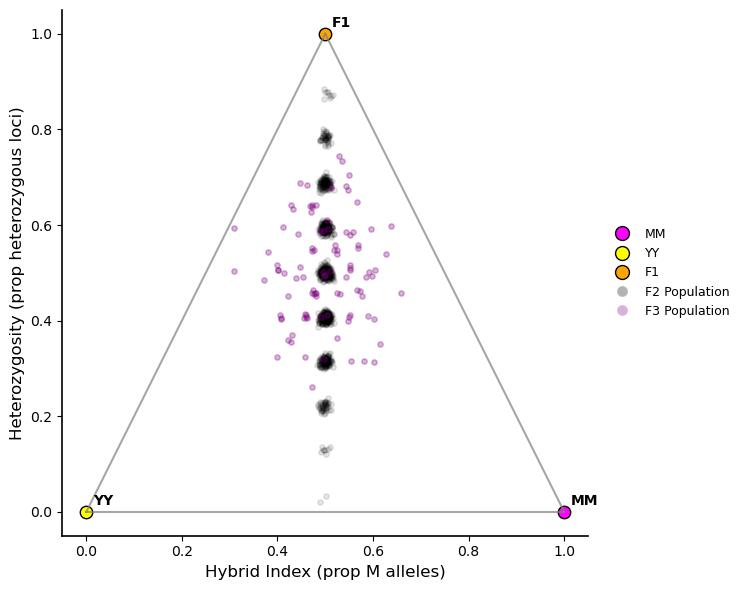

In [166]:
# Triangle plot

print("\n--- Plotting Triangle Plot ---")
fig, ax = plt.subplots(figsize=(8, 6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

ax.set_xlabel("Hybrid Index (prop M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (prop heterozygous loci)", fontsize=12)

# Plot F2 individuals
ax.scatter(
    hybrid_indices_f2,
    heterozygosities_f2,
    color='black',
    alpha=0.1, # Make F2 even more transparent to highlight F3 if desired
    s=15,
    label='F2 Population'
)

# Plot F3 individuals (NEW!)
ax.scatter(
    f3_hybrid_indices,
    f3_heterozygosities,
    color='purple', # Distinct color for F3
    alpha=0.3,
    s=15,
    label='F3 Population'
)

# Plot parents and F1
ax.scatter(parent_mm_hi, parent_mm_het, color='magenta', s=80, edgecolor='black', label='MM')
ax.scatter(parent_yy_hi, parent_yy_het, color='yellow', s=80, edgecolor='black', label='YY')
ax.scatter(f1_hi, f1_het, color='orange', s=80, edgecolor='black', label='F1')

# Add annotations
ax.annotate('MM', (parent_mm_hi, parent_mm_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('YY', (parent_yy_hi, parent_yy_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('F1', (f1_hi, f1_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Draw triangle edges
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)],
    [(0.5, 1.0), (1.0, 0.0)],
    [(0.0, 0.0), (1.0, 0.0)]
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

# Add legend (updated to include F3)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='MM'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='YY'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', alpha=0.3, markersize=8, label='F2 Population'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.3, markersize=8, label='F3 Population') # NEW!
]

ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()

### Heatmap & Prop plot

In [157]:
def plot_genotype_heatmap(genotype_numeric_data, num_individuals_to_sample,
                          chromosome_length, num_chromosomes, title_suffix=""):
    """
    Plots a heatmap of genotypes for a sample of individuals from any generation.

    Args:
        genotype_numeric_data (list of lists): Numeric genotypes for individuals.
        num_individuals_to_sample (int): How many individuals to randomly sample for the heatmap.
        chromosome_length (int): The number of loci per chromosome.
        num_chromosomes (int): The number of diploid chromosome pairs per individual.
        title_suffix (str): Text to add to the plot title (e.g., "F3 Population").
    """
    if not genotype_numeric_data:
        print(f"No {title_suffix} data available to plot heatmap.")
        return

    # Randomly sample individuals
    sampled_indices = random.sample(range(len(genotype_numeric_data)),
                                    min(num_individuals_to_sample, len(genotype_numeric_data)))
    sampled_genotypes = [genotype_numeric_data[i] for i in sampled_indices]

    genotype_matrix = np.array(sampled_genotypes)

    from matplotlib.colors import ListedColormap
    cmap_colors = {
        0: 'gold',      # YY
        1: 'lightgray', # MY
        2: 'deeppink'   # MM
    }
    cmap = ListedColormap([cmap_colors[0], cmap_colors[1], cmap_colors[2]])

    fig, ax = plt.subplots(figsize=(15, 8))
    im = ax.imshow(genotype_matrix, cmap=cmap, aspect='auto', interpolation='nearest',
                   vmin=0, vmax=2)

    ax.set_title(f'Genotype Heatmap {title_suffix} (Sample of {len(sampled_genotypes)} Individuals)')
    ax.set_xlabel('Locus Position (across all chromosomes)')
    ax.set_ylabel('Individual Index (sampled)')

    for i in range(1, num_chromosomes):
        boundary_x = i * chromosome_length - 0.5
        ax.axvline(x=boundary_x, color='black', linestyle='--', linewidth=1)

    patches = [
        mpatches.Patch(color=cmap_colors[0], label='YY (0)'),
        mpatches.Patch(color=cmap_colors[1], label='MY (1)'),
        mpatches.Patch(color=cmap_colors[2], label='MM (2)')
    ]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()


--- Plotting F2 Genotype Heatmap ---


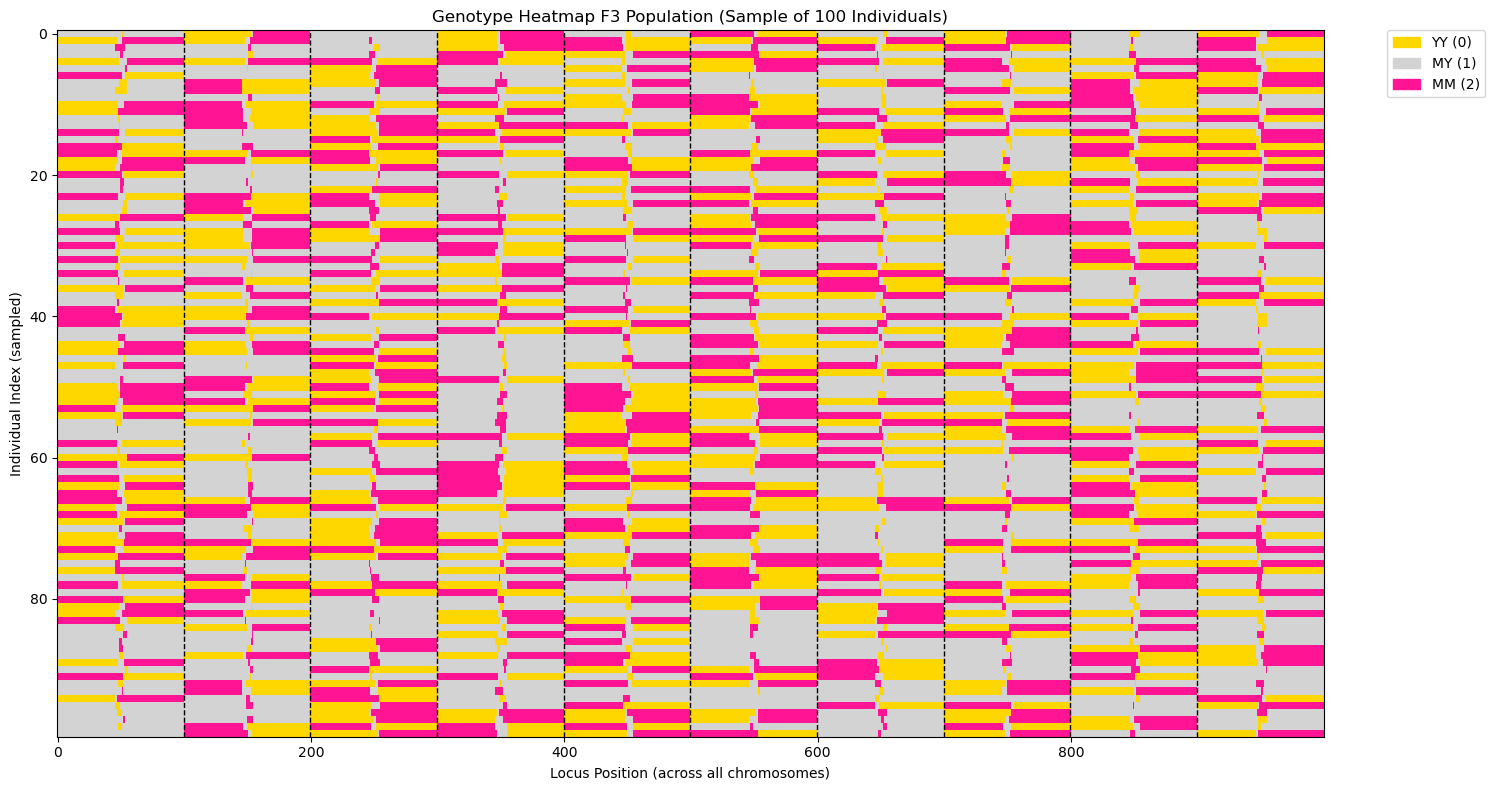

In [163]:
# Plot F2 Genotype Heatmap
print("\n--- Plotting F2 Genotype Heatmap ---")
plot_genotype_heatmap(f2_genotype_numeric_all, 100, chromosome_length, NUM_CHROMOSOMES_F2, "F3 Population")


--- Plotting F3 Genotype Heatmap ---


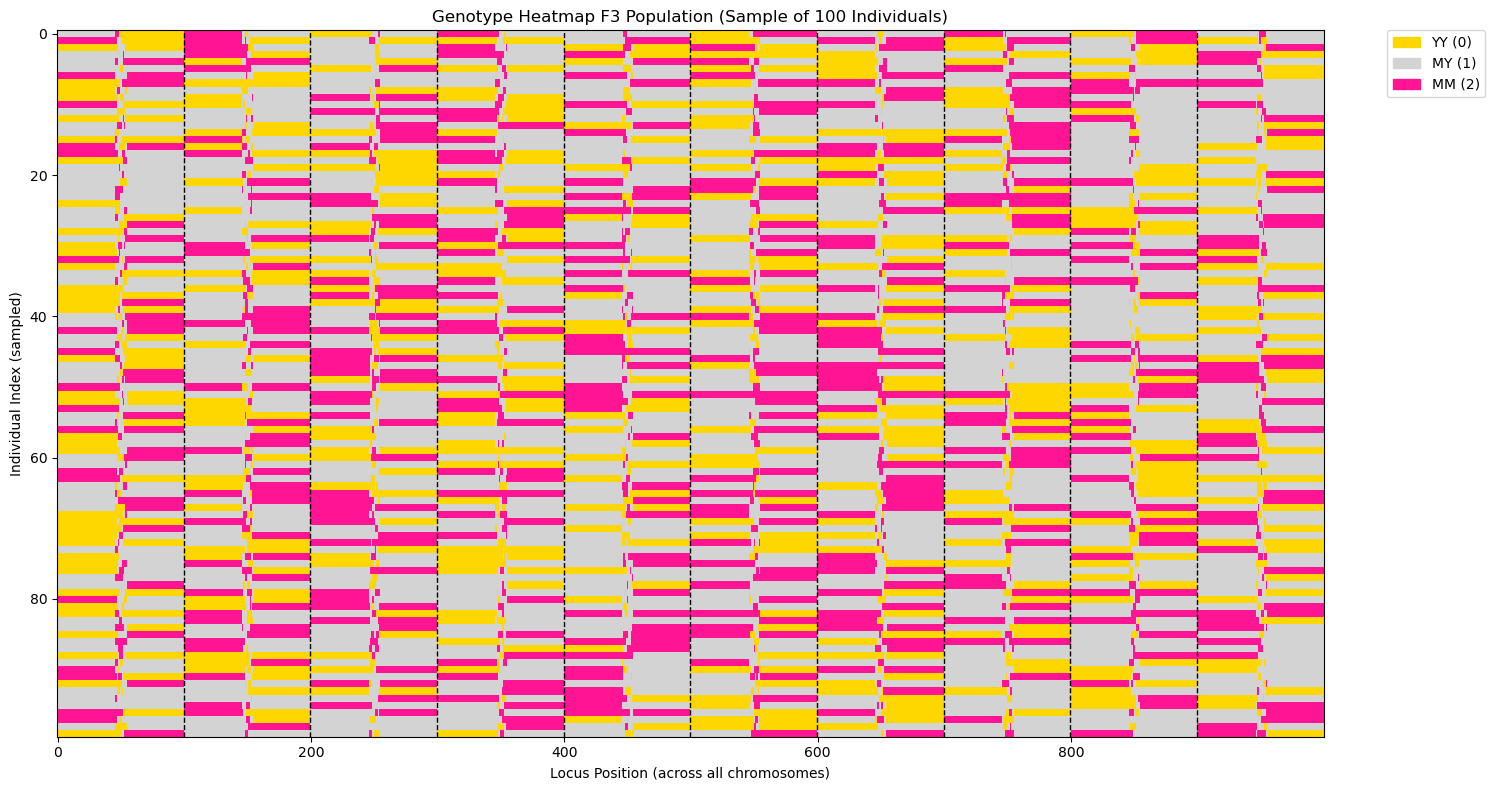

In [158]:
# --- 5. Plot F3 Genotype Heatmap ---
print("\n--- Plotting F3 Genotype Heatmap ---")
plot_genotype_heatmap(f3_genotype_numeric_all, 100, chromosome_length, NUM_CHROMOSOMES_F2, "F3 Population")

In [159]:
# Replace your existing `plot_f2_genotype_proportions` with this:
def plot_genotype_proportions(genotype_numeric_data, chromosome_length, num_chromosomes, title_suffix=""):
    """
    Plots the proportion of MM, MY, and YY genotypes at each locus across a population.

    Args:
        genotype_numeric_data (list of lists): Numeric genotypes for individuals.
        chromosome_length (int): The number of loci per chromosome.
        num_chromosomes (int): The number of diploid chromosome pairs per individual.
        title_suffix (str): Text to add to the plot title (e.g., "F3 Population").
    """
    if not genotype_numeric_data:
        print(f"No {title_suffix} data available to plot genotype proportions.")
        return

    total_loci = chromosome_length * num_chromosomes
    num_individuals = len(genotype_numeric_data)

    counts_yy = np.zeros(total_loci)
    counts_my = np.zeros(total_loci)
    counts_mm = np.zeros(total_loci)

    for individual_genotypes in genotype_numeric_data:
        for i, genotype in enumerate(individual_genotypes):
            if genotype == 0:
                counts_yy[i] += 1
            elif genotype == 1:
                counts_my[i] += 1
            elif genotype == 2:
                counts_mm[i] += 1

    proportions_yy = counts_yy / num_individuals
    proportions_my = counts_my / num_individuals
    proportions_mm = counts_mm / num_individuals

    fig, ax = plt.subplots(figsize=(15, 6))
    locus_indices = np.arange(total_loci)

    ax.bar(locus_indices, proportions_yy, color='gold', label='YY (0)', width=1)
    ax.bar(locus_indices, proportions_my, bottom=proportions_yy, color='lightgray', label='MY (1)', width=1)
    ax.bar(locus_indices, proportions_mm, bottom=proportions_yy + proportions_my, color='deeppink', label='MM (2)', width=1)

    ax.set_title(f'Average Genotype Proportions Along Chromosomes {title_suffix}')
    ax.set_xlabel('Locus Position')
    ax.set_ylabel('Proportion of Individuals')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, total_loci)

    for i in range(1, num_chromosomes):
        boundary_x = i * chromosome_length
        ax.axvline(x=boundary_x, color='black', linestyle='--', linewidth=1)
        ax.text(boundary_x - chromosome_length/2, 1.02, f'Chr {i}', ha='center', va='bottom', transform=ax.get_xaxis_transform(), fontsize=9, color='darkgray')

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


--- Plotting F2 Genotype Proportions ---


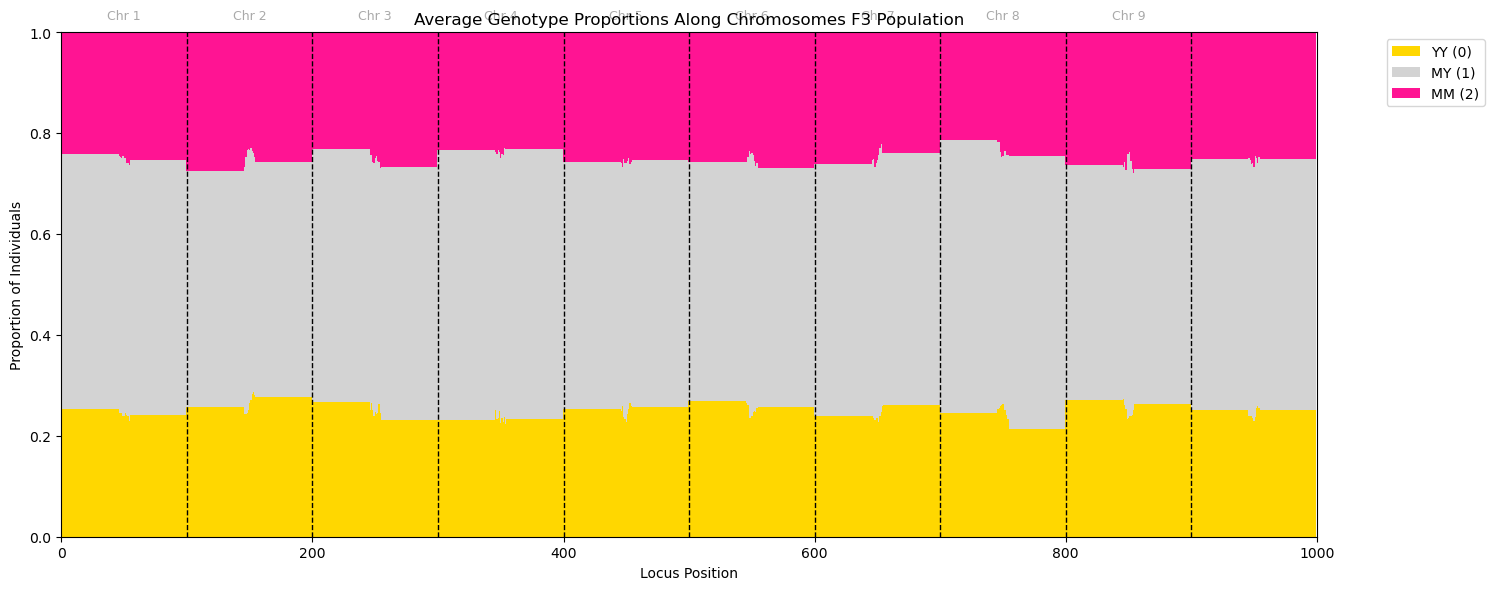

In [162]:
# Plot F2 Genotype
print("\n--- Plotting F2 Genotype Proportions ---")
plot_genotype_proportions(f2_genotype_numeric_all, chromosome_length, NUM_CHROMOSOMES_F2, "F3 Population")


--- Plotting F3 Genotype Proportions ---


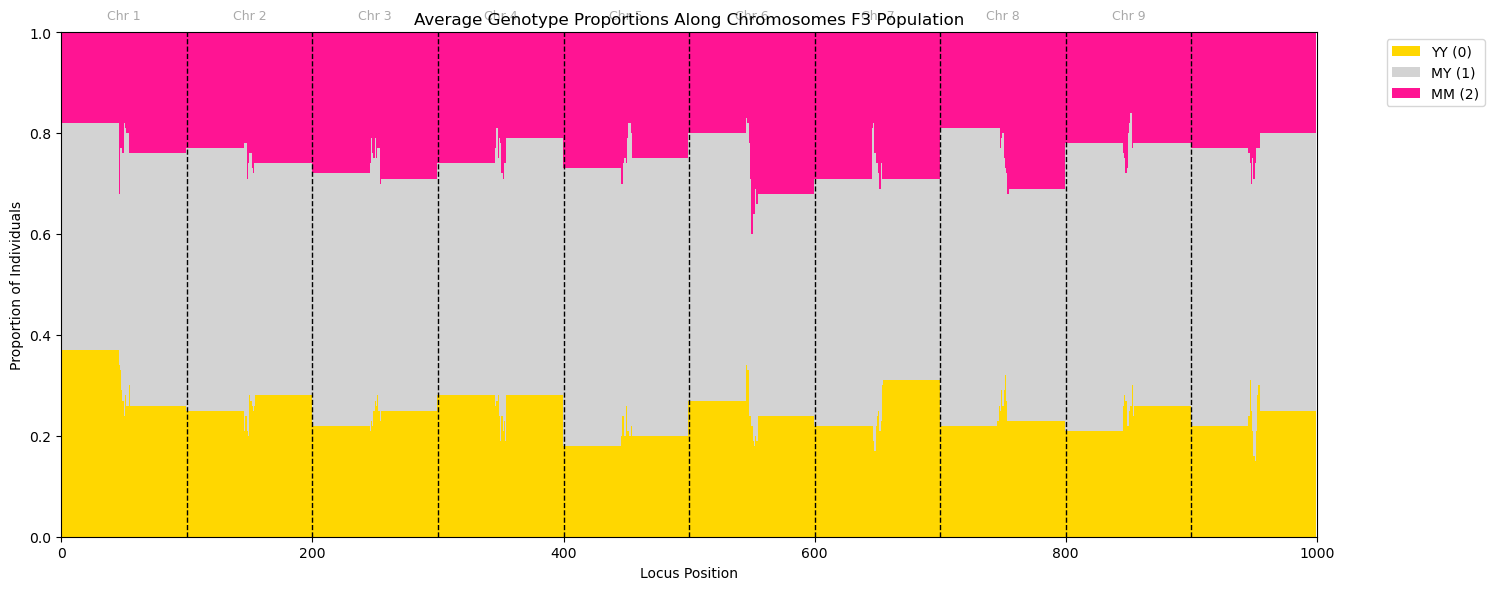

In [160]:
# Plot F3 Genotype
print("\n--- Plotting F3 Genotype Proportions ---")
plot_genotype_proportions(f3_genotype_numeric_all, chromosome_length, NUM_CHROMOSOMES_F2, "F3 Population")